In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict
import itertools
from datetime import datetime
import plotly.express as px
from scipy.spatial import ConvexHull

In [14]:
# define preferred airports for layovers
PREFERRED_AIRPORTS = ['NRT', 'HND', 'KIX', 'ICN', 'GMP', 'HKG', 'TPE', 'SIN']

In [15]:
# define classes
class Itinerary:
    def __init__(self, price, total_duration, layover_info, layover_count, 
                 baggage_fee, baggage_allowance, dep_time, arr_time, flight_id=None):
        self.flight_id = flight_id
        self.price = price
        self.total_duration = total_duration
        self.layover_info = layover_info
        self.layover_count = layover_count
        self.baggage_fee = baggage_fee
        self.baggage_allowance = baggage_allowance
        self.dep_time = dep_time
        self.arr_time = arr_time
    def __repr__(self):
        return (f'Itinerary(price={self.price}, total_duration={self.total_duration}, '
                f'layovers_info={self.layover_info}, layover_count={self.layover_count}, '
                f'baggage_fee={self.baggage_fee}, baggage_allowance={self.baggage_allowance}, '
                f'dep_time={self.dep_time}, arr_time={self.arr_time})')
    def layover_penalty(self):
        penalty = 0
        if self.layover_count == 0:
            return penalty
        elif self.layover_count == 3:
            penalty += 1e8
            return penalty
        elif self.layover_count == 2:
            penalty += 1e4
        for layover in self.layover_info:
            if self.layover_info[layover] < 180:
                penalty += 0
            elif 180 <= self.layover_info[layover] <= 600:
                if layover in PREFERRED_AIRPORTS:
                    penalty += 10
                else:
                    penalty += 1e4
            else:
                if layover in PREFERRED_AIRPORTS:
                    penalty += 0
                else:
                    penalty += 1e6
        return penalty
    def dep_time_penalty(self):
        penalty = 0
        if self.dep_time < 600 or self.dep_time > 120:
            penalty += 1e4
        return penalty
    def arr_time_penalty(self):
        penalty = 0
        if self.arr_time < 480 or self.arr_time > 600:
            penalty += 1e4
        return penalty

In [16]:
# parse data from csv files
def load_flights_from_csv(csv_path, segment, limit=None):
    """
    Load flight data from a CSV file and process it into a list of Itinerary objects

    Args:
        csv_path: Path to the CSV file
        segment: Flight segment identifier (str)
        limit: Maximum price (optional for filtering)

    Returns:
        List of Itinerary objects
    """
    df = pd.read_csv(csv_path)
    counter = 1
    flights = []
    for _, row in df.iterrows():
        try:
            price = int(row['Flight Price']) if not pd.isna(row['Flight Price']) else 0
            total_duration = int(row['Total Duration']) if not pd.isna(row['Total Duration']) else 0
            baggage_fee = int(row['Baggage Fee']) if not pd.isna(row['Baggage Fee']) else 0
            baggage_allowance = int(row['Free Baggage']) if not pd.isna(row['Free Baggage']) else 0


            layover_info = {}
            layover_raw = row['Layover Info']
            if isinstance(layover_raw, str) and layover_raw.strip():
                parts = [p.strip() for p in layover_raw.split(';')]
                for part in parts:
                    if ',' in part:
                        airport, duration = part.split(',')
                        layover_info[airport.strip()] = int(duration.strip())
            layover_count = int(row['Layover Count']) if not pd.isna(row['Layover Count']) else 0

            dep_time = str(row['Departure Times']).split(',')[0].strip() if not pd.isna(row['Departure Times']) else ""
            arr_time = str(row['Arrival Times']).split(',')[0].strip() if not pd.isna(row['Arrival Times']) else ""
        except Exception as e:
            continue
        if not layover_info:
            layover_info = {'NA': 0} # If no layover info, set to empty dict
        if 0 < price:
            flights.append(Itinerary(price, total_duration, layover_info, layover_count,
                                    baggage_fee, baggage_allowance, int(dep_time), int(arr_time), flight_id=segment+str(counter)))
            counter += 1
    return flights



In [17]:
outbound1210 = load_flights_from_csv('outbound1210.csv', 'sfojpn')
outbound1211 = load_flights_from_csv('outbound1211.csv', 'sfojpn')
outbound1212 = load_flights_from_csv('outbound1212.csv', 'sfojpn')
inbound0302 = load_flights_from_csv('inbound0302.csv', 'chinaewr')
inbound0303 = load_flights_from_csv('inbound0303.csv', 'chinaewr')
inbound0304 = load_flights_from_csv('inbound0304.csv', 'chinaewr')
jpnchina1218 = load_flights_from_csv('jpnchina1218.csv', 'jpnchina')
jpnchina1219 = load_flights_from_csv('jpnchina1219.csv', 'jpnchina')
jpnchina1220 = load_flights_from_csv('jpnchina1220.csv', 'jpnchina')

In [18]:
def flight_stats(flights):
    """
    Print max duration, max price, sorted durations, sorted prices, and flight IDs for a list of Itinerary objects.

    Args:
        flights: List of Itinerary objects

    Returns:
        max_duration: Maximum total duration of flights
        max_price: Maximum price of flights
        durations: Sorted list of total durations of flights
        prices: Sorted list of prices of flights
        ids: List of flight IDs
    """
    if flights:
        max_duration = max(flight.total_duration for flight in flights)
        max_price = max(flight.price for flight in flights)
        durations = sorted(flight.total_duration for flight in flights)
        prices = sorted(flight.price for flight in flights)
        ids = [flight.flight_id for flight in flights]
    else:
        print("No flights loaded.")
    return max_duration, max_price, durations, prices, ids

In [19]:
max_dur1, max_price1, dur_list1, price_list1, id_list1 = flight_stats(outbound1210)
max_dur2, max_price2, dur_list2, price_list2, id_list2 = flight_stats(outbound1211)
max_dur3, max_price3, dur_list3, price_list3, id_list3 = flight_stats(outbound1212)
max_dur4, max_price4, dur_list4, price_list4, id_list4 = flight_stats(jpnchina1218)
max_dur5, max_price5, dur_list5, price_list5, id_list5 = flight_stats(jpnchina1219)
max_dur6, max_price6, dur_list6, price_list6, id_list6 = flight_stats(jpnchina1220)
max_dur7, max_price7, dur_list7, price_list7, id_list7 = flight_stats(inbound0302)
max_dur8, max_price8, dur_list8, price_list8, id_list8 = flight_stats(inbound0303)
max_dur9, max_price9, dur_list9, price_list9, id_list9 = flight_stats(inbound0304)

In [20]:
def optimize_itineraries(itineraries: List[Itinerary], 
                        weights: dict = None):
    """
    Optimize itineraries based on multiple criteria using a weighted scoring system
    
    Args:
        itineraries: List of Itinerary objects
        weights: Dictionary of weights for each objective
    
    Returns:
        List of Itinerary objects of Pareto optimal solutions with no duplicates
    """

    norm_factors = {
        'price': max(it.price for it in itineraries) if itineraries else 1,
        'duration': max(it.total_duration for it in itineraries) if itineraries else 1,
        'layover_penalty': 1e8,
        'baggage_allowance': 2,
        'baggage_fee': max(it.baggage_fee for it in itineraries) if itineraries else 1,
        'dep_time_penalty': 1e4,
        'arr_time_penalty': 1e4
    }
    
    # Score calculation with constraints
    valid_itineraries = []
    for it in itineraries:
        # Calculate normalized scores
        scores = {
            'price': it.price / norm_factors['price'],
            'duration': it.total_duration / norm_factors['duration'],
            'layover_penalty': it.layover_penalty() / norm_factors['layover_penalty'],
            'baggage_allowance': it.baggage_allowance / norm_factors['baggage_allowance'],
            'baggage_fee': it.baggage_fee / norm_factors['baggage_fee'],
            'dep_time_penalty': it.dep_time_penalty() / norm_factors['dep_time_penalty'],
            'arr_time_penalty': it.arr_time_penalty() / norm_factors['arr_time_penalty']
        }
        
        # weighted sum
        total_score = sum(weights[obj] * scores[obj] for obj in weights)
        valid_itineraries.append((total_score, it))
    
    # sort by best score
    valid_itineraries.sort(key=lambda x: x[0])

    # filter out repeats
    unique_itineraries = {}
    for score, it in valid_itineraries:
        key = (
            it.price, 
            it.total_duration,
            frozenset(it.layover_info.items()),
            it.baggage_fee,
            it.baggage_allowance,
            it.dep_time,
            it.arr_time
        )
        if key not in unique_itineraries:
            unique_itineraries[key] = (score, it)
    
    unique_set = list(unique_itineraries.values())

    pareto_front = []

    for score, candidate in unique_set:
        dominated = False
        
        for _, other in valid_itineraries:
            if (other.price <= candidate.price and 
                other.total_duration <= candidate.total_duration and
                sum(other.layover_info.values()) <= sum(candidate.layover_info.values()) and
                other.baggage_allowance >= candidate.baggage_allowance and
                other.baggage_fee <= candidate.baggage_fee and
                other.dep_time_penalty() <= candidate.dep_time_penalty() and
                other.arr_time_penalty() <= candidate.arr_time_penalty() and 
                (other.price < candidate.price or 
                 other.total_duration < candidate.total_duration or
                 sum(other.layover_info.values()) < sum(candidate.layover_info.values()) or
                 other.baggage_allowance > candidate.baggage_allowance or
                 other.baggage_fee < candidate.baggage_fee or
                 other.dep_time_penalty() < candidate.dep_time_penalty() or 
                 other.arr_time_penalty() < candidate.arr_time_penalty())):
                dominated = True
                break
                
        if not dominated:
            pareto_front.append((score, candidate))
    
    return [it for score, it in pareto_front]

In [21]:
def print_optimal_itineraries(optimal_itineraries):
    print(f'\nFound {len(optimal_itineraries)} Pareto-optimal solutions:')
    for i, it in enumerate(optimal_itineraries):
        print(f'\nSolution {i+1}:')
        print(f'Price: ${it.price}')
        print(f'Duration: {it.total_duration} mins')
        print(f'Total Layover: {it.layover_count} times')
        print(f'Layover Info: {it.layover_info}')
        print(f'Baggage Allowance: {it.baggage_allowance} pieces')
        print(f'Baggage Fees: ${it.baggage_fee}')
        print(f'Dep Time Penalty: {it.dep_time_penalty():.1f}')
        print(f'Arr Time Penalty: {it.arr_time_penalty():.1f}')

In [22]:
def plot_pareto_front(itineraries, segment, obj1='price', obj2='duration'):
    """
    Plots the Pareto front for two objectives in a 2x2 grid.
    """
    getters = {
        'price': lambda it: it.price,
        'duration': lambda it: it.total_duration,
        'layover_penalty': lambda it: it.layover_penalty(),
        'baggage_fee': lambda it: it.baggage_fee,
        'baggage_allowance': lambda it: it.baggage_allowance,
        'dep_time_penalty': lambda it: it.dep_time_penalty(),
        'arr_time_penalty': lambda it: it.arr_time_penalty()
    }
    
    points = np.array([[getters[obj1](it), getters[obj2](it)] for it in itineraries])
    dep_time = [it.dep_time for it in itineraries]
    baggage_allowance = [it.baggage_allowance for it in itineraries]

    # Pareto front for minimization
    is_pareto = np.ones(len(points), dtype=bool)
    for i in range(len(points)):
        if is_pareto[i]:
            dominated_mask = np.all(points[i] <= points, axis=1) & np.any(points[i] < points, axis=1)
            is_pareto[dominated_mask] = False
    pareto_points = points[is_pareto]
    pareto_order = np.argsort(pareto_points[:, 0])
    pareto_sorted = pareto_points[pareto_order]

    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # 1. Price vs Duration Trade-off
    sc1 = axs[0, 0].scatter(points[:, 1], points[:, 0], c=baggage_allowance, cmap='viridis', alpha=0.7)
    fig.colorbar(sc1, ax=axs[0, 0], label='Baggage Allowance')
    axs[0, 0].set_xlabel('Duration (mins)')
    axs[0, 0].set_ylabel('Price ($)')
    axs[0, 0].set_title(segment + ' Price vs Duration')
    axs[0, 0].grid(True)

    # 2. Pareto Front: Price vs Duration
    axs[0, 1].scatter(points[:, 1], points[:, 0], c='gray', alpha=0.2, label='All solutions')
    axs[0, 1].scatter(pareto_sorted[:, 1], pareto_sorted[:, 0], c='red', s=50, label='Pareto optimal')
    axs[0, 1].plot(pareto_sorted[:, 1], pareto_sorted[:, 0], 'r--', alpha=0.5, label='Pareto frontier')
    axs[0, 1].scatter(pareto_sorted[:, 1].min(), pareto_sorted[:, 0].min(),
                      c='gold', s=200, marker='*', label='Ideal (unattainable)')
    axs[0, 1].set_xlabel(f'{obj2.capitalize()} (mins)')
    axs[0, 1].set_ylabel(f'{obj1.capitalize()} ($)')
    axs[0, 1].set_title(f'{segment} Pareto Front: {obj1.capitalize()} vs {obj2.capitalize()}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 3. Price vs Departure Time Trade-off
    sc2 = axs[1, 0].scatter(points[:, 0], dep_time, c=baggage_allowance, cmap='viridis', alpha=0.7)
    fig.colorbar(sc2, ax=axs[1, 0], label='Baggage Allowance')
    axs[1, 0].set_xlabel('Price ($)')
    axs[1, 0].set_ylabel('Departure Time (mins from 00:00)')
    axs[1, 0].set_title(segment + ' Price vs Departure Time')
    axs[1, 0].grid(True)

    # 4. Duration vs Departure Time Trade-off
    sc3 = axs[1, 1].scatter(points[:, 1], dep_time, c=baggage_allowance, cmap='viridis', alpha=0.7)
    fig.colorbar(sc3, ax=axs[1, 1], label='Baggage Allowance')
    axs[1, 1].set_xlabel('Duration (mins)')
    axs[1, 1].set_ylabel('Departure Time (mins from 00:00)')
    axs[1, 1].set_title(segment + ' Duration vs Departure Time')
    axs[1, 1].grid(True)

    
    plt.tight_layout()
    plt.savefig('pareto_front.png')
    plt.show()

In [23]:
def plot_pareto(optimal_itineraries, segment):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    prices = [it.price for it in optimal_itineraries]
    durations = [it.total_duration for it in optimal_itineraries] 
    dep_time = [it.dep_time for it in optimal_itineraries]
    arr_time = [it.arr_time for it in optimal_itineraries]
    baggage_allowance = [it.baggage_allowance for it in optimal_itineraries]

    sc = ax.scatter(prices, durations, dep_time, c=baggage_allowance,
                   cmap='viridis', s=100, depthshade=True)
    
    ax.set_xlabel('Price')
    ax.set_ylabel('Duration (mins)')
    ax.set_zlabel('Departure Time')
    plt.colorbar(sc, label='Baggage Allowance')
    plt.title(segment + ' 3D Pareto Front')
    plt.tight_layout()

    # Surface mesh (optional, for continuous approximation)
    ax.plot_trisurf(prices, durations, dep_time, color='red', alpha=0.1)

    fig = px.scatter_3d(
        x=prices, y=durations, z=dep_time,
        color=baggage_allowance, size=np.ones_like(prices)*10,
        labels={'x':'Price', 'y':'Duration', 'z':'Departure Time'},
        title='Interactive Pareto Front'
    )
    fig.update_layout(scene=dict(
        xaxis_title='Price ($)',
        yaxis_title='Duration (mins)',
        zaxis_title='Departure Time')
    )
    fig.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(durations, prices, c=baggage_allowance, cmap='viridis', alpha=0.7)
    plt.colorbar(label='Baggage Allowance')
    plt.xlabel('Duration (mins)')
    plt.ylabel('Price ($)')
    plt.title('Price vs Duration Trade-off')
    plt.grid(True)

    plt.figure(figsize=(10, 6))
    plt.scatter(prices, dep_time, c=baggage_allowance, cmap='plasma', alpha=0.7)
    plt.colorbar(label='Baggage Allowance')
    plt.xlabel('Price ($)')
    plt.ylabel('Departure Time (mins from 00:00)')
    plt.title('Price vs Departure Time Trade-off')
    plt.grid(True)
    
    plt.show()

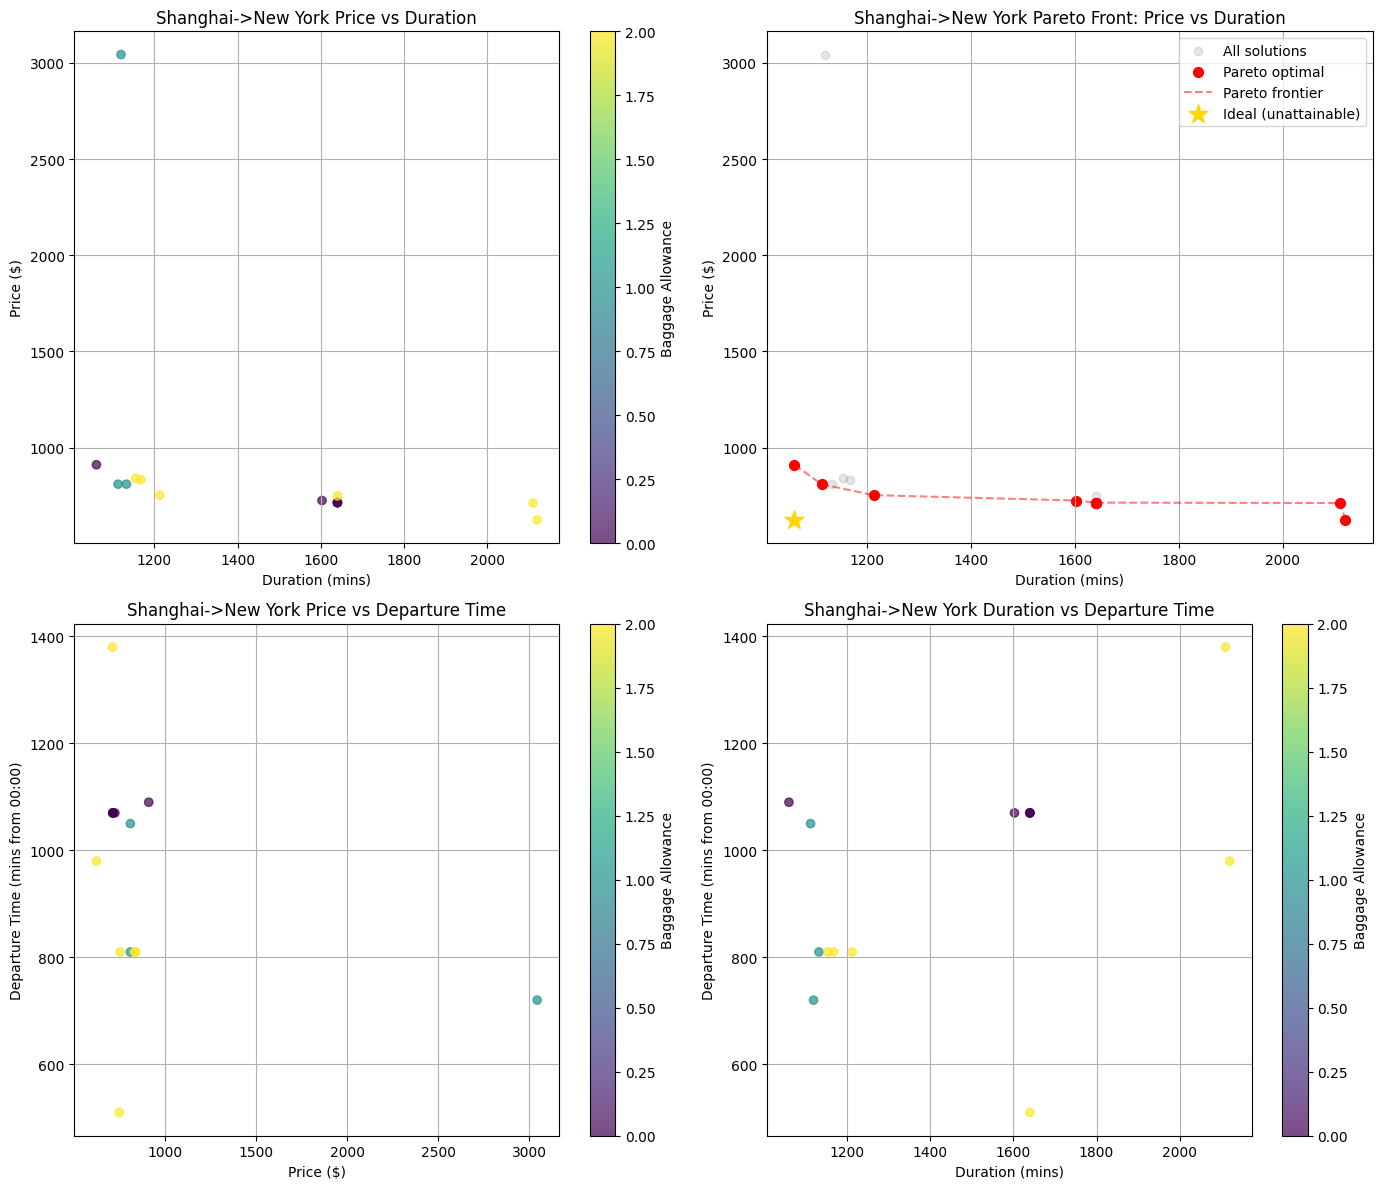

In [24]:
# Usage Example
if __name__ == '__main__':
    weights1 = {
        'price': 0.5,
        'duration': 0.2,
        'layover_penalty': 0.1,
        'baggage_allowance': 0.1,
        'baggage_fee': 0.0,
        'dep_time_penalty': 0.1,
        'arr_time_penalty': 0.0
    }
    weights2 = {
        'price': 0.5,
        'duration': 0.3,
        'layover_penalty': 0.1,
        'baggage_allowance': 0.1,
        'baggage_fee': 0.0,
        'dep_time_penalty': 0.0,
        'arr_time_penalty': 0.0
    }
    weights3 = {
        'price': 0.5,
        'duration': 0.1,
        'layover_penalty': 0.1,
        'baggage_allowance': 0.2,
        'baggage_fee': 0.0,
        'dep_time_penalty': 0.0,
        'arr_time_penalty': 0.1
    }

    optimal_outbound = optimize_itineraries(outbound1210 + outbound1211 + outbound1212, weights1)
    optimal_jpnchina = optimize_itineraries(jpnchina1218 + jpnchina1219 + jpnchina1220, weights2)
    optimal_inbound = optimize_itineraries(inbound0302 + inbound0303 + inbound0304, weights3)

    # plot_pareto_front(optimal_outbound, obj1='price', obj2='duration')
    # plot_pareto_front(optimal_jpnchina, obj1='price', obj2='duration')
    plot_pareto_front(optimal_inbound, 'Shanghai->New York', 'price', 'duration')